In [1]:
import numpy as np
import xarray as xr
import xrft
import gsw
import os.path as op
import dask.array.fft as fft
from dask.diagnostics import ProgressBar
from oceanmodes import instability_analysis_from_N2_profile as insta
from oceanmodes import neutral_modes_from_N2_profile as neu
from scipy.interpolate import PchipInterpolator as pchip
from xmitgcm import open_mdsdataset
from xgcm.grid import Grid
import matplotlib.ticker as tick
import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

In [2]:
ddir= '/swot/SUM02/channel_seasonality'

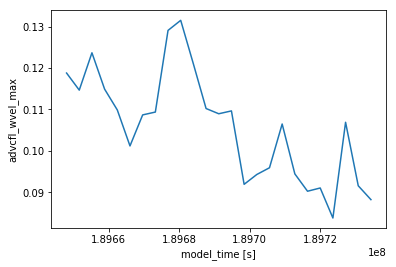

In [33]:
monitor = xr.open_dataset(op.join(ddir,'monitor.0006321600.t001.nc'))
monitor.advcfl_wvel_max.plot()

In [3]:
ys, dy = (4,1)
dt = 4e1
# df = 288
ts = int(360*86400*(ys+.5)/dt)
te = int(ts+360*86400*dy/dt)
print(ts,te)

3499200 4276800


In [4]:
dsmon = open_mdsdataset(op.join(ddir,'Dalma_Dar02km/runs'), 
#                        grid_dir=op.join(ddir,'02km_grid'),
                       iters=range(ts+64800,te+64800,64800),
                       prefix=['Ttave',
                              'wVeltave',
                              'uVeltave','vVeltave'],
                       delta_t=dt
                       ).sel(YC=slice(6e5,14e5),YG=slice(6e5,14e5))
dsmon

/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:   (XC: 500, XG: 500, YC: 400, YG: 401, Z: 76, Zl: 76, Zp1: 77, Zu: 76, time: 12)
Coordinates:
  * XC        (XC) >f4 1000.0 3000.0 5000.0 7000.0 9000.0 11000.0 13000.0 ...
  * YC        (YC) >f4 601000.0 603000.0 605000.0 607000.0 609000.0 611000.0 ...
  * XG        (XG) >f4 0.0 2000.0 4000.0 6000.0 8000.0 10000.0 12000.0 ...
  * YG        (YG) >f4 600000.0 602000.0 604000.0 606000.0 608000.0 610000.0 ...
  * Z         (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * Zp1       (Zp1) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * Zu        (Zu) >f4 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * Zl        (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
    rA        (YC, XC) >f4 dask.array<shape=(400, 500), chunksize=(400, 500)>
    dxG       (YG, XC) >f4 dask.array<shape=(401, 500), chunksize=(401, 500)>
    dyG       (YC, XG) >f4 dask.array<shape=(400, 500), chunksize=(400, 500)>
    Depth     (

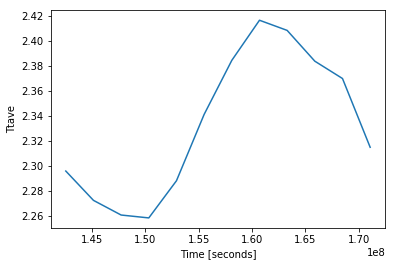

In [5]:
dsmon.Ttave.mean(['Z','YC','XC']).plot()

In [7]:
dsnap = open_mdsdataset(op.join(ddir,'Dalma_Dar02km/runs'), 
#                        grid_dir=op.join(ddir,'takaya/01km_grid'),
                       iters=range(ts,te-32400,32400), 
                       prefix=['T','U','V','W'], delta_t=dt
                       )
dsnap

/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (XC: 500, XG: 500, YC: 1000, YG: 1000, Z: 76, Zl: 76, Zp1: 77, Zu: 76, time: 17)
Coordinates:
  * XC       (XC) >f4 1000.0 3000.0 5000.0 7000.0 9000.0 11000.0 13000.0 ...
  * YC       (YC) >f4 1000.0 3000.0 5000.0 7000.0 9000.0 11000.0 13000.0 ...
  * XG       (XG) >f4 0.0 2000.0 4000.0 6000.0 8000.0 10000.0 12000.0 ...
  * YG       (YG) >f4 0.0 2000.0 4000.0 6000.0 8000.0 10000.0 12000.0 ...
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * Zp1      (Zp1) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * Zu       (Zu) >f4 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 -16.1 ...
  * Zl       (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
    rA       (YC, XC) >f4 dask.array<shape=(1000, 500), chunksize=(1000, 500)>
    dxG      (YG, XC) >f4 dask.array<shape=(1000, 500), chunksize=(1000, 500)>
    dyG      (YC, XG) >f4 dask.array<shape=(1000, 500), chunksize=(1000, 500)>
    Depth    (YC, XC) 

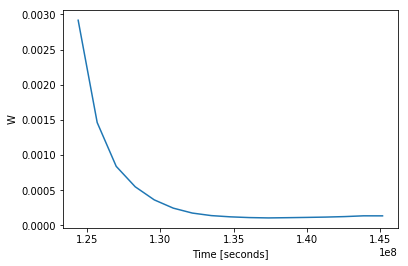

In [8]:
np.sqrt((dsnap.W**2).mean(['Zl','YC','XC'])).plot()

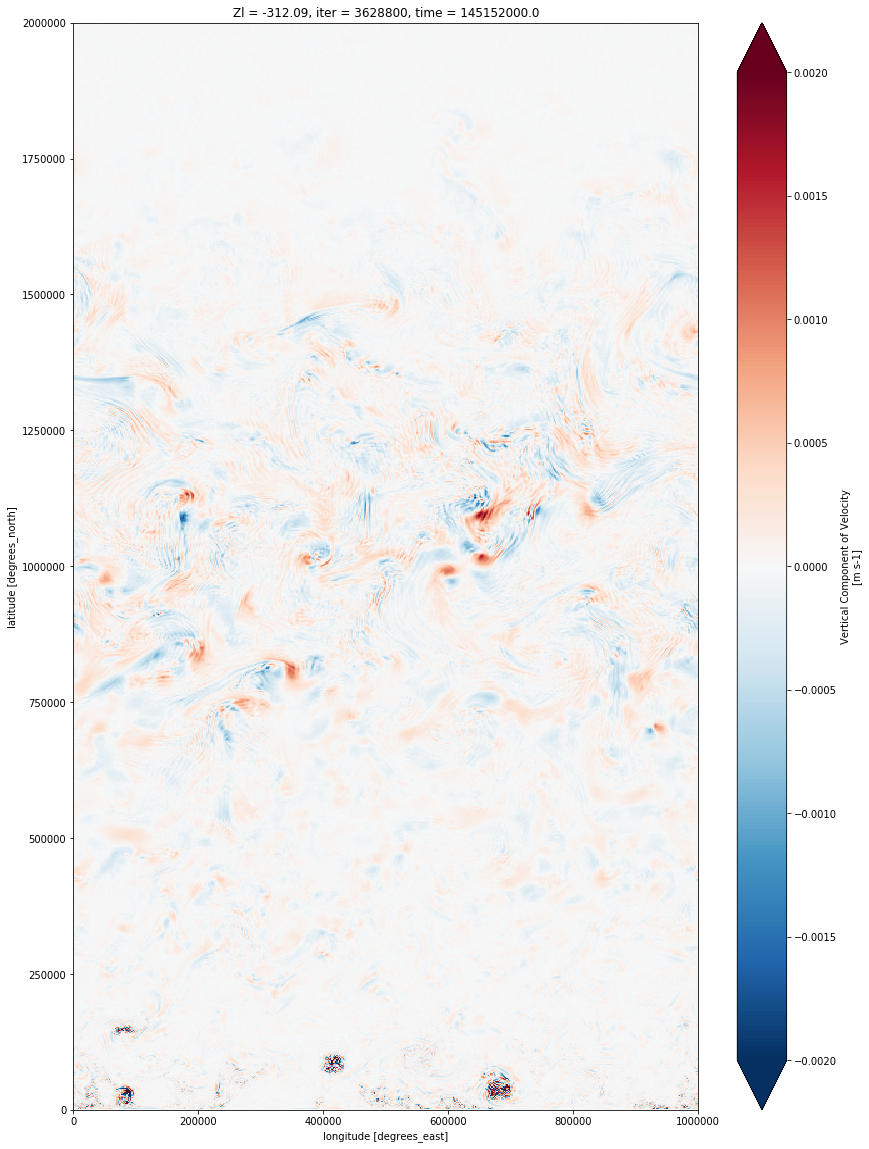

In [9]:
dsnap.W[-1,33].plot(figsize=(14,20), vmax=0.002)

In [46]:
dsave = open_mdsdataset(op.join(ddir,'Dalma_Dar02km/runs'), 
#                        grid_dir=op.join(ddir,'takaya/01km_grid'),
                       iters=range(ts+64800,te,64800), 
                       prefix=['Ttave','PTRtave03'], delta_t=dt
                       )
dsave

/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:    (XC: 500, XG: 500, YC: 1000, YG: 1000, Z: 76, Zl: 76, Zp1: 77, Zu: 76, time: 2)
Coordinates:
  * XC         (XC) >f4 1000.0 3000.0 5000.0 7000.0 9000.0 11000.0 13000.0 ...
  * YC         (YC) >f4 1000.0 3000.0 5000.0 7000.0 9000.0 11000.0 13000.0 ...
  * XG         (XG) >f4 0.0 2000.0 4000.0 6000.0 8000.0 10000.0 12000.0 ...
  * YG         (YG) >f4 0.0 2000.0 4000.0 6000.0 8000.0 10000.0 12000.0 ...
  * Z          (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * Zp1        (Zp1) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 ...
  * Zu         (Zu) >f4 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * Zl         (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
    rA         (YC, XC) >f4 dask.array<shape=(1000, 500), chunksize=(1000, 500)>
    dxG        (YG, XC) >f4 dask.array<shape=(1000, 500), chunksize=(1000, 500)>
    dyG        (YC, XG) >f4 dask.array<shape=(1000, 500), chunksize=(1000, 500)>
    Depth   

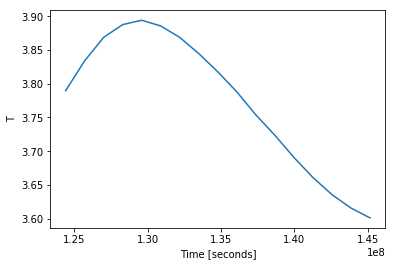

In [10]:
dsnap['T'][:,:33].mean(['Z','YC','XC']).plot()

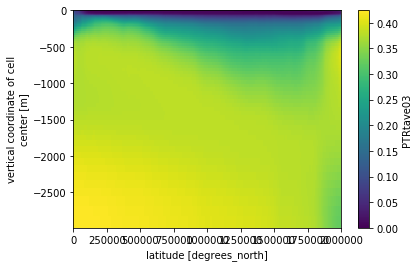

In [47]:
(dsave.PTRtave03.mean(['time','XC'])*1e3).plot()

In [15]:
ds1H = open_mdsdataset(op.join(ddir,'Dalma_Dar02km/runs'), 
#                       grid_dir=op.join(ddir,'takaya/01km_grid'),
                      iters=range(int(ts+180*86400/dt),int(ts+180*86400/dt+60*86400/dt),90),
                      prefix=['Snap1H'], delta_t=dt
                      )
ds1H

/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (XC: 500, XG: 500, YC: 1000, YG: 1000, Z: 76, Zl: 76, Zp1: 77, Zu: 76, time: 1440)
Coordinates:
  * XC       (XC) >f4 1000.0 3000.0 5000.0 7000.0 9000.0 11000.0 13000.0 ...
  * YC       (YC) >f4 1000.0 3000.0 5000.0 7000.0 9000.0 11000.0 13000.0 ...
  * XG       (XG) >f4 0.0 2000.0 4000.0 6000.0 8000.0 10000.0 12000.0 ...
  * YG       (YG) >f4 0.0 2000.0 4000.0 6000.0 8000.0 10000.0 12000.0 ...
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * Zp1      (Zp1) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * Zu       (Zu) >f4 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 -16.1 ...
  * Zl       (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
    rA       (YC, XC) >f4 dask.array<shape=(1000, 500), chunksize=(1000, 500)>
    dxG      (YG, XC) >f4 dask.array<shape=(1000, 500), chunksize=(1000, 500)>
    dyG      (YC, XG) >f4 dask.array<shape=(1000, 500), chunksize=(1000, 500)>
    Depth    (YC, XC

In [7]:
ds1D = open_mdsdataset(ddir, 
#                        grid_dir=op.join(ddir,'takaya/01km_grid'),
                       iters=range(int(ts+180*86400/dt)+2880,te+2880,2880), 
                       prefix=['MOMtave'], delta_t=2e1
                       )
ds1D

/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (XC: 1000, XG: 1000, YC: 2000, YG: 2000, Z: 76, Zl: 76, Zp1: 77, Zu: 76, time: 48)
Coordinates:
  * XC       (XC) >f4 500.0 1500.0 2500.0 3500.0 4500.0 5500.0 6500.0 7500.0 ...
  * YC       (YC) >f4 500.0 1500.0 2500.0 3500.0 4500.0 5500.0 6500.0 7500.0 ...
  * XG       (XG) >f4 0.0 1000.0 2000.0 3000.0 4000.0 5000.0 6000.0 7000.0 ...
  * YG       (YG) >f4 0.0 1000.0 2000.0 3000.0 4000.0 5000.0 6000.0 7000.0 ...
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * Zp1      (Zp1) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * Zu       (Zu) >f4 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 -16.1 ...
  * Zl       (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
    rA       (YC, XC) >f4 dask.array<shape=(2000, 1000), chunksize=(2000, 1000)>
    dxG      (YG, XC) >f4 dask.array<shape=(2000, 1000), chunksize=(2000, 1000)>
    dyG      (YC, XG) >f4 dask.array<shape=(2000, 1000), chunksize=(2000, 100

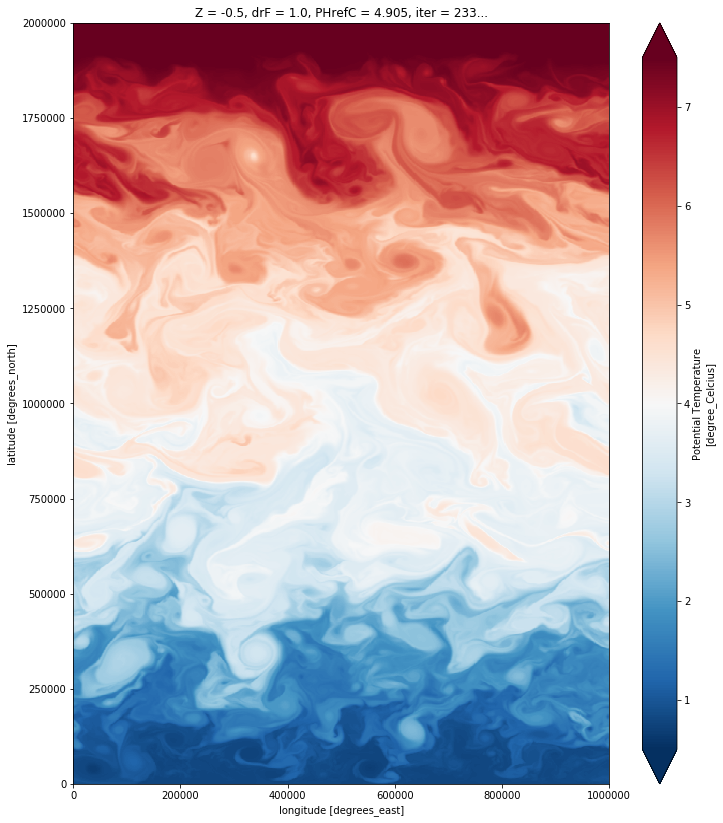

In [4]:
dsnap['T'][-1,0].plot(figsize=(12,14), vmax=7.5, vmin=.5, cmap='RdBu_r')

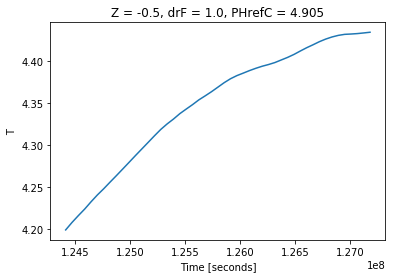

In [57]:
dsnap['T'][:,0].sel(YC=slice(6e5,14e5)).mean(['YC','XC']).plot()

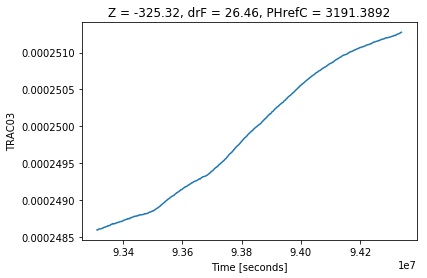

In [34]:
ds1H.TRAC03[:,33].sel(YC=slice(6e5,14e5)).mean(['YC','XC']).plot()

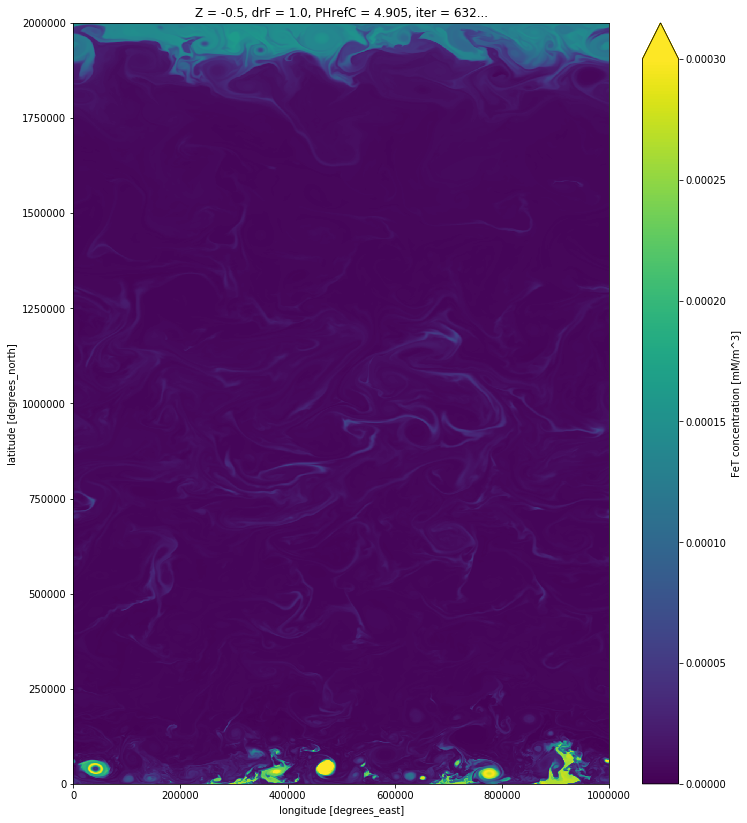

In [58]:
ds1H.TRAC03[-1,0].plot(figsize=(12,14), vmax=3e-4)

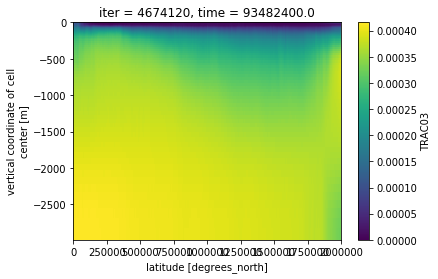

In [11]:
ds1H.TRAC03[-1].mean('XC').plot()

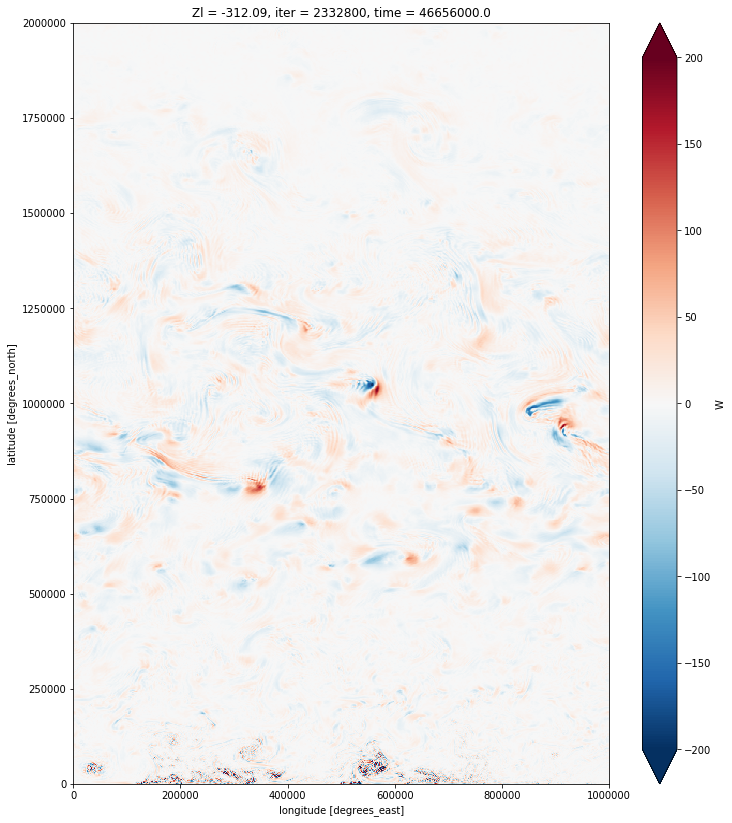

In [10]:
(dsnap.W[-1,33]*86400).plot(figsize=(12,14), vmin=-2e2, vmax=2e2, cmap='RdBu_r')

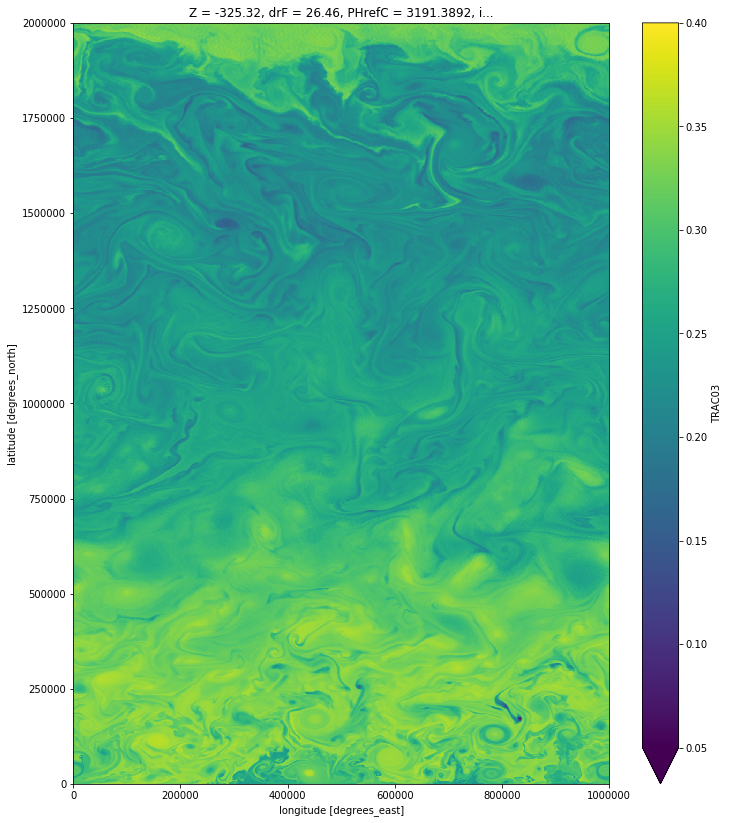

In [22]:
(ds1H.TRAC03[-1,33]*1e3).plot(figsize=(12,14), vmin=.05, vmax=.4)

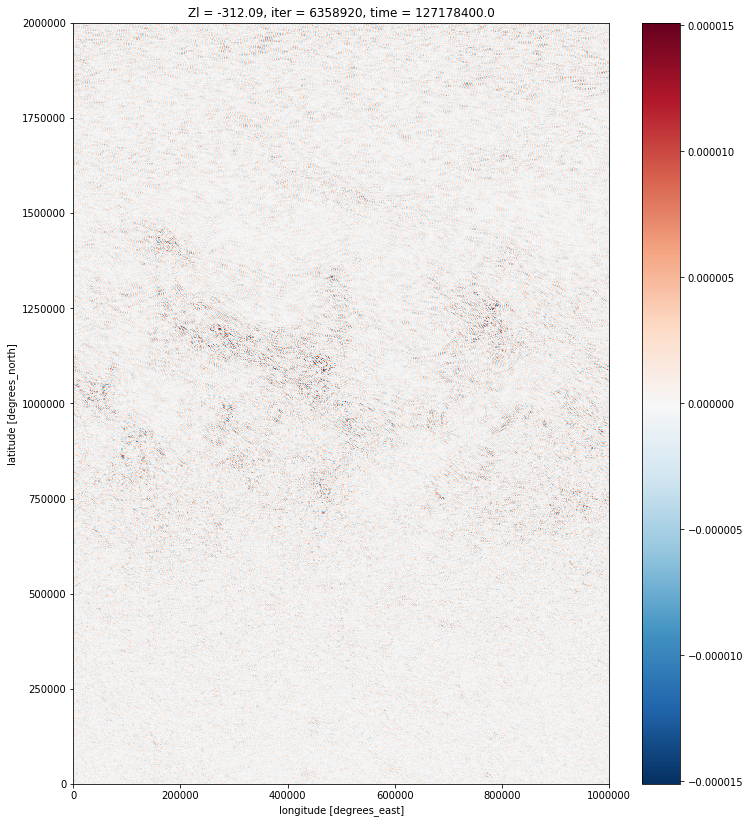

In [24]:
grid1 = Grid(ds1H,periodic=['X'])
(ds1H.WVEL[-1,33]*grid1.interp(ds1H.TRAC03,'Z',boundary='fill')[-1,33]).plot(figsize=(12,14), cmap='RdBu_r')

In [28]:
for i in range(24):
    fig, ax = plt.subplots(figsize=(12,14))
    fig.set_tight_layout(True)
    im = ax.pcolormesh(ds1H.XC*1e-3, ds1H.YC*1e-3,
                      ds1H.WVEL[i,33]*86400, 
                      vmin=-3e3, vmax=3e3, cmap='RdBu_r', rasterized=True)
    ax.set_xlabel(r"[km]", fontsize=12)
    ax.set_ylabel(r"[km]", fontsize=12)
    cbar = fig.colorbar(im)
    cbar.set_label(r"[m d$^{-1}$]", fontsize=12)
    plt.savefig(op.join(ddir,'takaya/Figures/w_1Hsnap_z312m_01km_%03d.png' % i))
    plt.close()

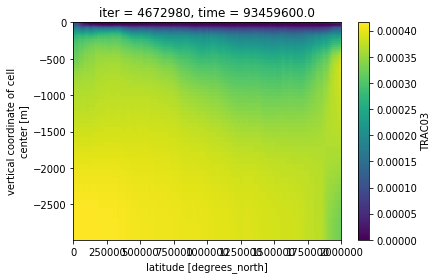

In [11]:
ds1H.TRAC03[-1].mean(['XC']).plot()

In [ ]:
grid = Grid(ds1H, periodic=['X'])

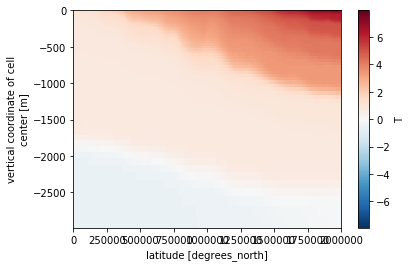

In [26]:
dsnap['T'].mean(['time','XC']).plot()

In [63]:
with ProgressBar():
    zeta = (grid.diff(ds15D['VVEL'][-1,0],'X')/grid.diff(ds15D['VVEL'].XC,'X')
           - grid.diff(ds15D['UVEL'][-1,0],'Y',boundary='fill')/grid.diff(ds15D['UVEL'].YC,'Y',boundary='fill')
           ).sel(YG=slice(6e5,14e5)).compute()
zeta

[########################################] | 100% Completed | 10.4s


<xarray.DataArray (YG: 801, XG: 1000)>
array([[ 8.909130e-06, -1.525857e-06,  5.657442e-06, ..., -2.733119e-06,
         5.854517e-07,  5.091501e-07],
       [ 5.978246e-06, -6.465555e-06, -7.318515e-06, ..., -1.063711e-05,
        -7.668409e-06, -3.706228e-06],
       [-2.375880e-06,  8.556021e-07, -5.736832e-06, ..., -6.983507e-06,
        -6.928518e-06, -4.114635e-06],
       ...,
       [ 2.018391e-05,  2.052622e-05,  1.913924e-05, ...,  1.347307e-05,
         1.752983e-05,  2.017586e-05],
       [ 1.103973e-05,  1.863582e-05,  1.713034e-05, ...,  1.268699e-05,
         1.654079e-05,  1.875579e-05],
       [-3.448924e-06,  1.629686e-05,  1.456009e-05, ...,  1.192494e-05,
         1.523936e-05,  1.713997e-05]], dtype=float32)
Coordinates:
  * YG       (YG) >f4 600000.0 601000.0 602000.0 603000.0 604000.0 605000.0 ...
  * XG       (XG) >f4 0.0 1000.0 2000.0 3000.0 4000.0 5000.0 6000.0 7000.0 ...

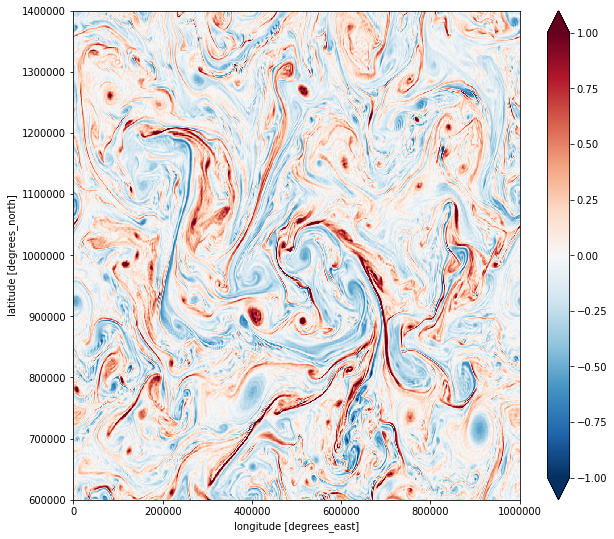

In [64]:
f0 = -1.1e-4
(zeta/f0).plot(figsize=(10,9), cmap='RdBu_r', vmax=1., vmin=-1.)

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.43320849e-05, 1.52309613e-03,
        9.35986267e-02, 1.24764669e+00, 1.00719101e+00, 1.26092385e-01,
        1.86641698e-02, 3.45817728e-03, 1.14232210e-03, 4.36953808e-04,
        1.43570537e-04, 4.99375780e-05, 1.87265918e-05, 0.00000000e+00]),
 array([-4. , -3.6, -3.2, -2.8, -2.4, -2. , -1.6, -1.2, -0.8, -0.4,  0. ,
         0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ]),
 <a list of 20 Patch objects>)

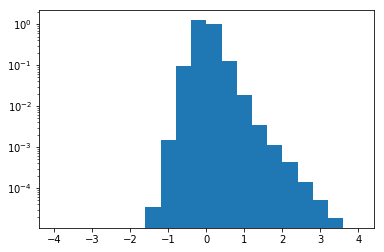

In [65]:
plt.hist(zeta.data.ravel()/f0, density=True, bins=20, range=(-4,4), log=True)

# Cross Spectra

In [9]:
grid1 = Grid(ds1H.sel(YC=slice(6e5,14e5),YG=slice(6e5,14e5)), periodic=['X'])
w15 = ds1H.WVEL.sel(YC=slice(6e5,14e5))[-int(24*15):,33]
Fe15 = grid1.interp(ds1H.TRAC03.sel(YC=slice(6e5,14e5)),'Z',boundary='fill')[-int(24*15):,33]
w15kf = xrft.dft(w15, dim=['XC'], detrend='constant')
Fe15kf = xrft.dft(Fe15, dim=['XC'], detrend='constant')
with ProgressBar():
    w15kf = xrft.dft(w15kf.chunk({'time':len(w15kf.time),'YC':100}), dim=['time'], window=True, detrend='linear').compute()
    Fe15kf = xrft.dft(Fe15kf.chunk({'time':len(Fe15kf.time),'YC':100}), dim=['time'], window=True, detrend='linear').compute()
w15kf

/home/takaya/xrft/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:
/home/takaya/xrft/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:
/home/takaya/xrft/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


[########################################] | 100% Completed | 19min 13.8s


/home/takaya/xrft/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


[########################################] | 100% Completed | 39min 38.4s


<xarray.DataArray 'rechunk-merge-4453164f4ddb984b027b81a8aa28aaba' (freq_time: 360, YC: 800, freq_XC: 1000)>
array([[[-0.031442+1.043002e-15j,  0.009604-2.693193e-02j, ...,
          0.001722-4.991812e-02j,  0.009604+2.693193e-02j],
        [-0.088464+9.471590e-16j,  0.014859-4.040237e-02j, ...,
         -0.012089-8.267767e-02j,  0.014859+4.040237e-02j],
        ...,
        [-0.005709+1.092876e-16j,  0.015086+3.173722e-03j, ...,
          0.001611-4.497175e-03j,  0.015086-3.173722e-03j],
        [ 0.004295-2.966377e-16j,  0.015983-6.599396e-03j, ...,
          0.011475+1.544955e-03j,  0.015983+6.599396e-03j]],

       [[ 0.027841+7.781025e-03j,  0.006543+3.754826e-02j, ...,
         -0.007274+4.891263e-02j, -0.03665 -1.685162e-02j],
        [ 0.060393+3.374376e-02j, -0.023739+3.668907e-02j, ...,
         -0.009843+6.465329e-02j, -0.02484 -4.422519e-02j],
        ...,
        [-0.002485-1.273573e-02j, -0.014597-5.317435e-03j, ...,
          0.006682-3.189533e-03j, -0.013595+1.660018e-0

In [10]:
wFe15 = (w15kf*np.conj(Fe15kf)).real.mean('YC')
wFe15

<xarray.DataArray (freq_time: 360, freq_XC: 1000)>
array([[-7.393321e-08,  3.638315e-08, -9.778130e-09, ...,  3.368733e-08,
        -9.778130e-09,  3.638315e-08],
       [-2.246818e-08,  4.088558e-08,  1.536411e-09, ...,  3.035570e-09,
         2.369015e-09,  3.418700e-08],
       [ 3.229075e-08,  2.067412e-08, -2.526890e-08, ..., -1.749277e-08,
         1.391539e-08,  2.761449e-08],
       ...,
       [-7.877550e-09,  5.241298e-09,  5.273362e-08, ...,  2.364033e-08,
         1.953526e-08,  4.073985e-08],
       [ 3.229075e-08,  2.761449e-08,  1.391539e-08, ...,  1.511975e-08,
        -2.526890e-08,  2.067412e-08],
       [-2.246818e-08,  3.418700e-08,  2.369015e-09, ...,  3.883697e-08,
         1.536411e-09,  4.088558e-08]])
Coordinates:
  * freq_time          (freq_time) float64 -0.0002083 -0.0002072 -0.000206 ...
  * freq_XC            (freq_XC) float64 -0.0005 -0.000499 -0.000498 ...
    freq_time_spacing  float64 1.157e-06

In [ ]:
w15_2 = (w15kf)

(array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 <a list of 6 Text yticklabel objects>)

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


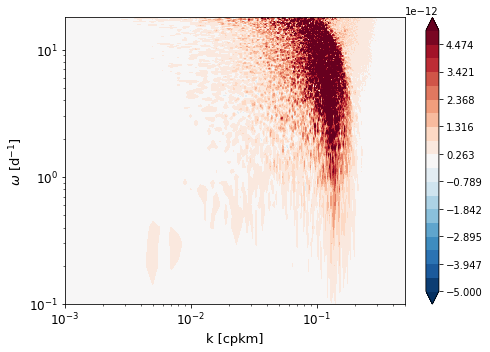

In [27]:
fig, ax = plt.subplots(figsize=(7,5))
fig.set_tight_layout(True)
im = ax.contourf(wFe15.freq_XC[501:]*1e3, wFe15.freq_time[181:]*86400, 
                 wFe15[181:,501:]*wFe15.freq_XC[501:]*wFe15.freq_time[181:], 
                cmap='RdBu_r', levels=1e-10*np.linspace(-.05,.05,20), extend='both')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'k [cpkm]', fontsize=13)
ax.set_ylabel(r'$\omega$ [d$^{-1}$]', fontsize=13)
fig.colorbar(im, ax=ax)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

In [17]:
ds1H.Zl[33]

<xarray.DataArray 'Zl' ()>
array(-312.09, dtype=float32)
Coordinates:
    Zl       >f4 -312.09
Attributes:
    standard_name:      depth_at_upper_w_location
    long_name:          vertical coordinate of upper cell interface
    units:              m
    positive:           down
    axis:               Z
    c_grid_axis_shift:  -0.5

In [ ]:
grid1 = Grid(ds1H.sel(YC=slice(6e5,14e5),YG=slice(6e5,14e5)), periodic=['X'])
w45 = ds1H.WVEL.sel(YC=slice(6e5,14e5))[-int(24*45):,33]
Fe45 = grid1.interp(ds1H.TRAC03.sel(YC=slice(6e5,14e5)),'Z',boundary='fill')[-int(24*45):,33]
w45kf = xrft.dft(w45, dim=['XC'], detrend='constant')
Fe45kf = xrft.dft(Fe45, dim=['XC'], detrend='constant')
w45kf = xrft.dft(w45kf.chunk({'time':len(w45kf.time),'YC':100}), dim=['time'], window=True, detrend='linear').compute()
Fe45kf = xrft.dft(Fe45kf.chunk({'time':len(Fe45kf.time),'YC':100}), dim=['time'], window=True, detrend='linear').compute()
with ProgressBar():
    wFe45 = (w45kf*np.conj(Fe45kf)).real.mean('YC').compute()
    w245 = (w45kf*np.conj(w45kf)).real.mean('YC').compute()
wFe45

/home/takaya/xrft/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:
/home/takaya/xrft/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


(array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 <a list of 7 Text yticklabel objects>)

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


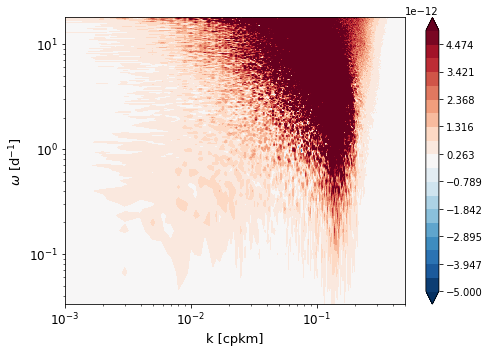

In [16]:
fig, ax = plt.subplots(figsize=(7,5))
fig.set_tight_layout(True)
im = ax.contourf(wFe45.freq_XC[501:]*1e3, wFe45.freq_time[541:]*86400, 
                 wFe45[541:,501:]*wFe45.freq_XC[501:]*wFe45.freq_time[541:], 
                cmap='RdBu_r', levels=1e-10*np.linspace(-.05,.05,20), extend='both')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'k [cpkm]', fontsize=13)
ax.set_ylabel(r'$\omega$ [d$^{-1}$]', fontsize=13)
fig.colorbar(im, ax=ax)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)